In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

print(tf.__version__)

2.2.0


In [2]:
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist, celeba=ld.load_celeba)

In [3]:
from pae.fid_score_tf2 import *

In [4]:
PROJECT_PATH = "../../" 
PARAMS_PATH  = os.path.join(PROJECT_PATH,'params')
param_file   = 'params_fmnist_-1_40_infoGAN_VAE_best_params_noaugment_full_sigmaVAE_beta0'
params       = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

flow = 'tag7_130'

In [5]:
ROOT  = '/global/cscratch1/sd/vboehm/RNF/'
LOCAL = '/global/homes/v/vboehm/codes/PAE'


In [6]:
params['module_dir'] = params['module_dir'].replace('/global/scratch/vboehm/rnf/',ROOT)
params['data_dir'] = '/global/cscratch1/sd/vboehm/Datasets'
params['plot_dir'] = os.path.join(LOCAL,'plots',params['label'])
pickle.dump(params, open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))

In [7]:
print(params['plot_dir'])

/global/homes/v/vboehm/codes/PAE/plots/fmnist/class-1/latent_size40/net_type_infoGAN/loss_VAE/best_params_noaugment_full_sigmaVAE_beta0


In [8]:
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])
# if not os.path.isdir(params['data_dir']):
#     os.makedirs(params['data_dir'])

In [9]:
load_func                                          = load_funcs[params['data_set']]
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'])

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5


In [10]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],flow)

In [11]:
shape = params['data_shape']
shape = np.append(-1,shape)
print(shape)

x_valid = np.reshape(x_valid, shape)

[-1 28 28  1]


In [12]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [13]:
tf.reset_default_graph()

data          = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)
latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
sample_size   = tf.placeholder_with_default(params['batch_size'], shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_path, trainable=False)
prior         = tfd.MultivariateNormalDiag(tf.zeros(params['latent_size']), scale_identity_multiplier=1.0)

encoded, _    = tf.split(encoder({'x':data},as_dict=True)['z'], 2, axis=-1)
decoded       = decoder({'z':encoded},as_dict=True)['x']

decoded_latent= decoder({'z':latent_point},as_dict=True)['x']

sigma         = tf.reduce_mean(tf.sqrt(tf.square(data-decoded)),axis=0)

samples         = prior.sample(sample_size)
decoded_samples = decoder({'z':samples},as_dict=True)['x']
nvp_samples     = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':samples}, as_dict=True)['fwd_pass']
u_samples       = nvp({'z_sample':encoded,'sample_size':1, 'u_sample':samples}, as_dict=True)['bwd_pass']
decoded_nvp_samples = decoder({'z':nvp_samples},as_dict=True)['x']

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
rec, d            = sess.run([decoded,data], feed_dict={data:x_valid[0:params['batch_size']]})
recs=[]
delta = len(x_valid)%params['batch_size']
for ii in range(len(x_valid)//params['batch_size']):
    recs+=[sess.run(decoded, feed_dict={data:x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]})]
data_sample=np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
recs+=[sess.run(decoded, feed_dict={data:data_sample})]
recs = np.asarray(recs).reshape(shape)[0:len(x_valid)]



In [20]:
from sklearn.utils import resample
 

In [21]:
recon_diff = np.square(x_valid-recs)

In [27]:
res =[]
res1=[]
res2=[]
for ii in range(1000):
    sample = resample(recon_diff, replace=True, n_samples=len(recon_diff))
    res.append(np.mean(sample))
    res1.append(np.percentile(a=sample.flatten(),q=68))
    res2.append(np.percentile(a=sample.flatten(),q=95))


In [29]:
print(np.mean(res),np.std(res),np.mean(res1),np.std(res1),np.mean(res2),np.std(res2))

0.006019282276957859 5.88562340647649e-05 0.0010279894077446278 1.219170555930639e-05 0.02866003831686317 0.00032192273084854454


In [17]:
full_sigma = np.sqrt(np.mean(np.square(x_valid-recs),axis=0))
mean_sigma = np.mean(np.square(x_valid-recs))
print(mean_sigma)
mean_var   = np.mean(full_sigma**2)
# plt.figure()
# plt.title('pixel-wise variance')
# plt.imshow((full_sigma**2).reshape([64,64,3]), cmap='gray')
# plt.colorbar()
# plt.axis('off')
# plt.savefig(os.path.join(params['plot_dir'],'measured_sigma.pdf'),bbox_inches='tight')
# plt.show()
params['full_sigma']=full_sigma
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))
print('mean variance', mean_var)
print('minimum variance', np.min(full_sigma**2))
print('maximal variance', np.max(full_sigma**2))

0.006016512702987211
mean variance 0.006016512702987169
minimum variance 9.323339604944209e-08
maximal variance 0.01330005530488079


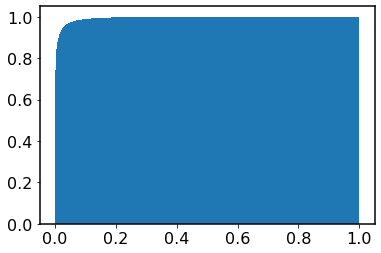

mean 0.006016512702987211
68 and 95 percentiles: 0.0010282504468681157 0.028643094984327926


In [18]:
_ = plt.hist(((x_valid-recs)**2).flatten(), density=True, bins=1000, cumulative=True, log=False)
plt.show()
print('mean',np.mean((x_valid-recs).flatten()**2))
print('68 and 95 percentiles:', np.percentile(a=(x_valid-recs).flatten()**2,q=68),np.percentile(a=(x_valid-recs).flatten()**2,q=95))

In [19]:
kde = pickle.load(open('kde_VAE_fit.pkl','rb'))

In [20]:
kde_sample = kde.sample(10500)
kde_sample_x = []
for ii in range(10500//params['batch_size']):
    jj=ii+1
    kde_sample_x.append(sess.run(decoded_latent,feed_dict={latent_point:kde_sample[ii*params['batch_size']:jj*params['batch_size']]}))

In [21]:
kde_sample_x = np.asarray(kde_sample_x).reshape((-1,28,28))

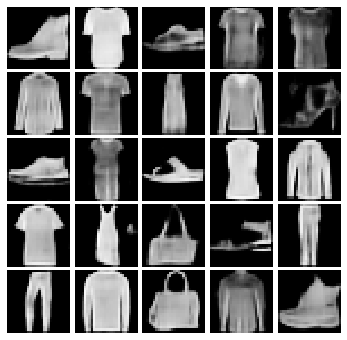

In [22]:

plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((kde_sample_x[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'kde_samples_5.pdf'),bbox_inches='tight')
plt.show()

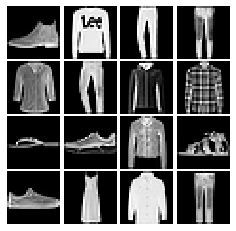

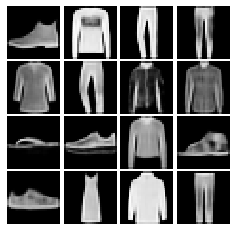

In [23]:

jj=1
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((d[ii]+0.5)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
#plt.savefig(os.path.join(params['plot_dir'],'orig_valid_set.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze(rec[ii]+0.5),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

#plt.savefig(os.path.join(params['plot_dir'],'rec_valid_set.pdf'),bbox_inches='tight')
plt.show()

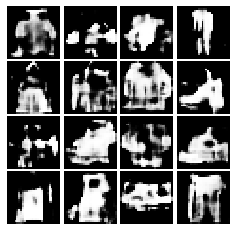

In [24]:
random_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_samples+=[sess.run(decoded_samples)]
random_samples=np.asarray(random_samples).reshape(shape)[0:10000]

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((random_samples[ii]+0.5)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
#plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()

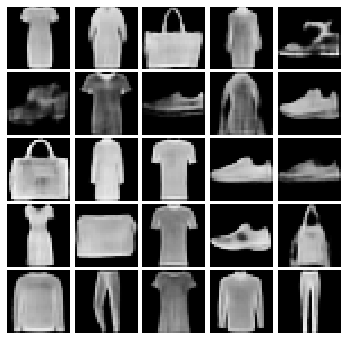

In [25]:
random_nvp_samples=[]
for ii in range(10000//params['batch_size']+1):
    random_nvp_samples+=[sess.run(decoded_nvp_samples)]
random_nvp_samples=np.asarray(random_nvp_samples).reshape((-1,28,28))[0:10000]
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((random_nvp_samples[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'nvp_samples_5.pdf'),bbox_inches='tight')
plt.show()

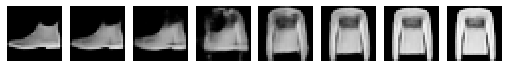

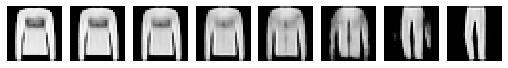

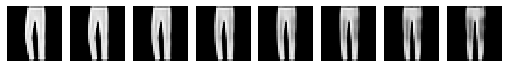

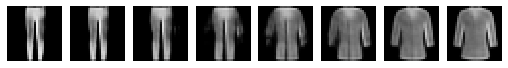

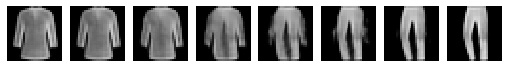

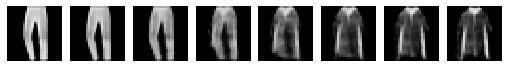

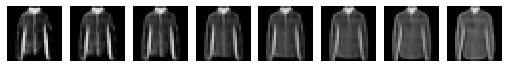

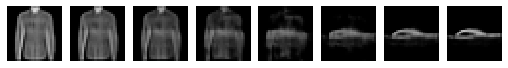

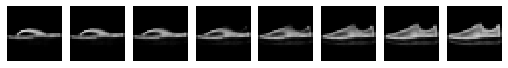

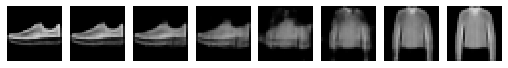

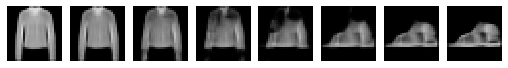

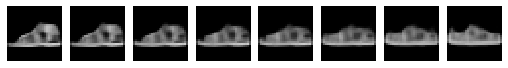

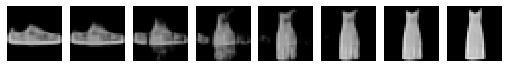

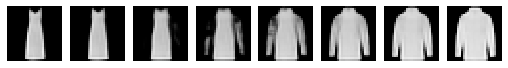

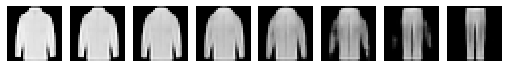

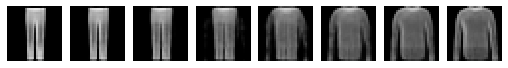

In [26]:
try:
    latent_point1 = sess.run(encoded, feed_dict={data:x_valid[0:params['batch_size']]})
    latent_point2 = sess.run(encoded, feed_dict={data:x_valid[1:params['batch_size']+1]})
except:
    latent_point1 = sess.run(encoded)
    latent_point2 = sess.run(encoded)    
#latent_point1, latent_point2 = pickle.load(open('latent_points_for_interpolation_celeba.pkl','rb'))
interp = latent_point1+(latent_point2-latent_point1)*np.arange(8)[:, None,None]/8.

decoded_interp=[]

for jj in range(min(params['batch_size'],16)):
    fig, ax = plt.subplots(1,8,figsize=(9,1))
    for ii in range(8):
        decoded_interp=sess.run(decoded_latent, feed_dict={latent_point:interp[ii]})[jj]
        ax[ii].imshow(np.squeeze(decoded_interp.reshape(shape))+0.5, vmin=0,vmax=1, cmap='gray')
        ax[ii].axis('off')
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(os.path.join(params['plot_dir'],'interp%d.pdf'%jj),bbox_inches='tight')
    plt.show()

In [22]:
model_path = '/global/cscratch1/sd/vboehm/RNF/modules/fmnist/class-1/latent_size40/net_type_infoGAN/loss_VAE/best_params_full_sigmaVAE_beta0/GIS/'
samples = np.load(os.path.join(model_path,'samples0.npy'))


In [23]:
GIS_x = []
for ii in range(10000//params['batch_size']):
    jj=ii+1
    GIS_x.append(sess.run(decoded_latent,feed_dict={latent_point:samples[ii*params['batch_size']:jj*params['batch_size']]}))

In [24]:
delta = len(samples)%params['batch_size']
data_sample = np.concatenate((samples[(ii+1)*params['batch_size']:len(samples)],samples[0:params['batch_size']-delta]))
GIS_x.append(sess.run(decoded_latent,feed_dict={latent_point:data_sample}))

In [25]:
GIS_x = np.asarray(GIS_x).reshape((-1, 28,28,1))[0:len(samples)]

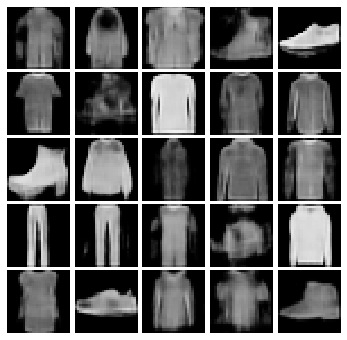

In [26]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(25):
    plt.subplot(5,5,ii+1)
    plt.imshow(np.squeeze((GIS_x[ii]+0.5).reshape(shape)),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'gis_samples_5.pdf'),bbox_inches='tight')
plt.show()

In [31]:
def evaluate_fid_score(fake_images, real_images,norm=True):
    #np.random.shuffle(real_images)
    assert(len(real_images))
    assert(len(fake_images))
    real_images = real_images[0:10000]
    fake_images = fake_images[0:10000]
    real_images = preprocess_fake_images(real_images, norm)
    fake_images = preprocess_fake_images(fake_images, norm)

    inception_path = check_or_download_inception()

    create_inception_graph(inception_path)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print('calculating tf features...')
    real_out = get_activations_tf(real_images, sess)
    fake_out = get_activations_tf(fake_images, sess)
    fid_result = fid_score(real_out, fake_out)
    sess.close()

    return fid_result

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import sklearn
from sklearn.utils import resample

In [34]:
fid_scores = []
for ii in range(2):
    print(ii)
    sample_1 = resample(GIS_x,replace=True,n_samples=9000)
    sample_2 = resample(x_valid,replace=True,n_samples=9000)
    fid_scores.append(evaluate_fid_score(sample_1,sample_2))
    print(fid_scores[-1])

0
norm =  True
norm =  True
Instructions for updating:
Use tf.gfile.GFile.
calculating tf features...
56.812842954697985
1
norm =  True
norm =  True
calculating tf features...
57.538949911707796


In [30]:
fid_scores = []
for ii in range(2):
    print(ii)
    sample_1 = resample(random_samples,replace=True,n_samples=9000)
    sample_2 = resample(x_valid,replace=True,n_samples=9000)
    fid_scores.append(evaluate_fid_score(sample_1,sample_2))
    print(fid_scores[-1])

0
norm =  True
norm =  True
Instructions for updating:
Use tf.gfile.GFile.
calculating tf features...
126.96875049637474
1
norm =  True
norm =  True
calculating tf features...
126.94128609455977


126.95501829546726 126.95996188779395 126.96737727628398


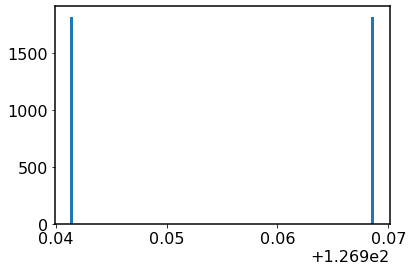

In [31]:
fid_scores=np.asarray(fid_scores)
_ = plt.hist(fid_scores, density=True, bins=100)
print(np.mean(fid_scores),np.percentile(fid_scores,68),np.percentile(fid_scores,95))

0
norm =  True
norm =  True
calculating tf features...
27.979700439779137
1
norm =  True
norm =  True
calculating tf features...
27.862038058719527
27.920869249249332 27.94204847784006 27.973817320726155


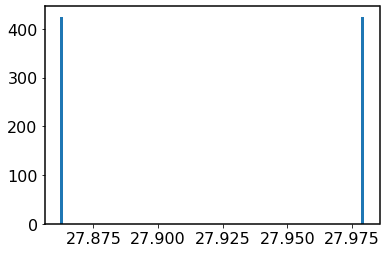

In [32]:
fid_scores = []
for ii in range(2):
    print(ii)
    sample_1 = resample(recs,replace=True,n_samples=10000)
    sample_2 = resample(x_valid,replace=True,n_samples=10000)
    fid_scores.append(evaluate_fid_score(sample_1,sample_2))
    print(fid_scores[-1])
    
fid_scores=np.asarray(fid_scores)
_ = plt.hist(fid_scores, density=True, bins=100)
print(np.mean(fid_scores),np.percentile(fid_scores,68),np.percentile(fid_scores,95))

0
norm =  True
norm =  True
calculating tf features...
1
norm =  True
norm =  True
calculating tf features...
32.91004920466598 33.08805805144039 33.35507132160201


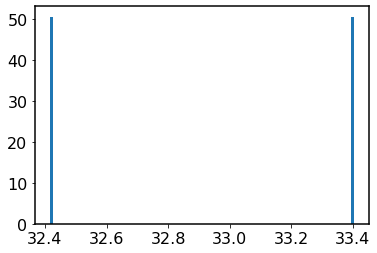

In [34]:
fid_scores = []
for ii in range(2):
    print(ii)
    sample_1 = resample(np.expand_dims(random_nvp_samples,-1),replace=True,n_samples=10000)
    sample_2 = resample(x_valid,replace=True,n_samples=10000)
    fid_scores.append(evaluate_fid_score(sample_1,sample_2))
    
fid_scores=np.asarray(fid_scores)
_ = plt.hist(fid_scores, density=True, bins=100)
print(np.mean(fid_scores),np.percentile(fid_scores,68),np.percentile(fid_scores,95))

In [35]:
random_nvp_samples.shape

(10000, 28, 28)

0
norm =  True
norm =  True
calculating tf features...
1
norm =  True
norm =  True
calculating tf features...
30.23299774436362 30.258001169001044 30.295506305957186


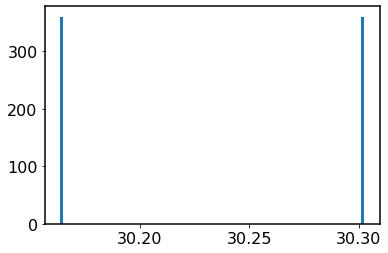

In [36]:
fid_scores = []
for ii in range(2):
    print(ii)
    sample_1 = resample(np.expand_dims(kde_sample_x,-1),replace=True,n_samples=10000)
    sample_2 = resample(x_valid,replace=True,n_samples=10000)
    fid_scores.append(evaluate_fid_score(sample_1,sample_2))
    
fid_scores=np.asarray(fid_scores)
_ = plt.hist(fid_scores, density=True, bins=100)
print(np.mean(fid_scores),np.percentile(fid_scores,68),np.percentile(fid_scores,95))